In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

## basics

- $\theta$ 与 $\pi_\theta(s,a)$（给定 $\theta$（策略参数） 关于 s, a 的函数），基于 $\theta$ 找到 $\pi_\theta$
    - $\theta$ 是策略参数
    - $\pi_\theta(s,a)$ 是策略（base $\theta$，policy)
    - $\pi$ 表示 distribution
- 策略迭代（策略梯度，policy gradient）的含义
    - $\theta_0\rightarrow \pi_0$, $\theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \pi_1$

## 更新 pi 的计算方式

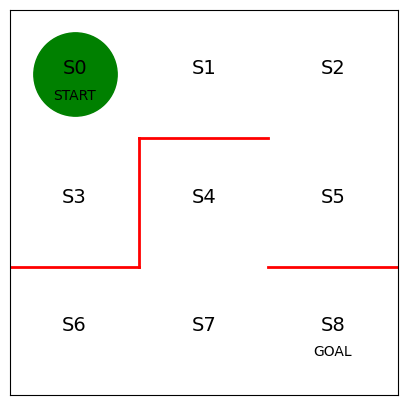

In [2]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# plt.plot([1, 1], [0, 1], color='red', linewidth=2)
# plt.plot([1, 2], [2, 2], color='red', linewidth=2)
# plt.plot([2, 2], [2, 1], color='red', linewidth=2)
# plt.plot([2, 3], [1, 1], color='red', linewidth=2)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# plt.axis('off')
plt.tick_params(axis='both', which='both', 
                bottom=False, top=False, 
                right=False, left=False,
                labelbottom=False, labelleft=False
               )
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [3]:
# border & barrier
# ↑, →, ↓, ←（顺时针）
# row index: given state
# col index: posible action
# (state, action) matrix
# 跟环境对齐
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )

In [4]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [5]:
cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

$$
\begin{split}
\mathbb P_{k} & = \frac{\exp(z_k\cdot \beta)}{\sum_i \exp(z_i\cdot \beta)}\\
&=\frac{\exp(\frac{z_k}T)}{\sum_i \exp(\frac{z_i}T)}=\frac{\exp(\beta\cdot{z_k})}{\sum_i \exp(\beta\cdot{z_i})}
\end{split}
$$

In [6]:
# 基于 softmax，更 general 的概率化方式
def softmax_cvt_theta_0_to_pi(theta, beta=1.0):
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta*beta)
    for r in range(m):
        pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
    pi = np.nan_to_num(pi)
    return pi

In [7]:
softmax_cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

## 与环境（Env）交互

In [8]:
# 维护着状态，以及 step 函数的返回
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0
        pass
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        # state, reward, done, _
        return self.state, 1, done, {}

In [ ]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.actions = list(range(4))
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )
#         self.pi = self._cvt_theta_0_to_pi(self.theta_0)
        self.theta = self.theta_0
        self.pi = self._softmax_cvt_theta_to_pi()
        
        self.eta = 0.1
        
    def _cvt_theta_to_pi(self):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta[r, :] / np.nansum(self.theta[r, :])
        return np.nan_to_num(pi)
    
    def _softmax_cvt_theta_to_pi(self, beta=1.):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        exp_theta = np.exp(self.theta*beta)
        for r in range(m):
            pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
        return np.nan_to_num(pi)
    
    def update_theta(self, s_a_history):
        T = len(s_a_history) - 1
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not(np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]
                    sa_ij = [sa for sa in s_a_history if (sa[0] == i and sa[1] == j)]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij - self.pi[i, j]*N_i)/T
        self.theta = self.theta + self.eta * delta_theta
        return self.theta
    
    def update_pi(self):
        self.pi = self._softmax_cvt_theta_to_pi()
        return self.pi
    
    def choose_action(self, state):
        # 依概率分布 \pi_\theta 选择 action
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action